# The Battle of the Neighborhoods

## Safest Neighborhood in London Borough

### Import Libraries

In [1]:
import requests # library to handle requests
import bs4 # library for web scrapping
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import os # Library to get the current working directory
import json # Library  to parse JSON file into a Python dictionary

#!conda install -c conda-forge geocoder --yes
#import geocoder

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

# Plotting libraries
import matplotlib.cm as cm
import matplotlib.colors as colors

# Library for clustering algorithm
from sklearn.cluster import KMeans

# libraries for displaying maps
import folium 

print('Libraries imported.')

Libraries imported.


In [2]:
# Reading the JSON file for wiki page
web_link = 'https://en.wikipedia.org/wiki/List_of_London_boroughs'
response = requests.get(web_link)

try:
    response.raise_for_status()
    soup_obj = bs4.BeautifulSoup(response.text, 'html.parser')
    
except Exception as exc:
    print('Error while downloading the webpage.. %s' % exc)

In [3]:
content = soup_obj.find('table', attrs={'class':"wikitable sortable"})

In [4]:
import re
column_name = ['London_Borough'] 
data_frame = pd.DataFrame(columns=column_name)

for row in content.findAll('tr'):
    line_item = row.findAll('td')
    if line_item:
        name1 = line_item[0].text.strip()
        re_obj = re.compile('\[')
        split_obj = re_obj.split(name1)
        borough_name = split_obj[0].strip()
        data_frame = data_frame.append({'London_Borough': borough_name},
                                        ignore_index=True)
        
data_frame

,London_Borough
0,Barking and Dagenham
1,Barnet
2,Bexley
3,Brent
4,Bromley
5,Camden
6,Croydon
7,Ealing
8,Enfield
9,Greenwich


### Getting crime record dataset

In [7]:
cwd = os.getcwd()
csv_file_path = os.path.join(os.getcwd(), 'london_crime_by_lsoa.csv')

In [8]:
csv_file = pd.read_csv(csv_file_path)
csv_file.head()

,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01001116,Croydon,Burglary,Burglary in Other Buildings,0,2016,11
1,E01001646,Greenwich,Violence Against the Person,Other violence,0,2016,11
2,E01000677,Bromley,Violence Against the Person,Other violence,0,2015,5
3,E01003774,Redbridge,Burglary,Burglary in Other Buildings,0,2016,3
4,E01004563,Wandsworth,Robbery,Personal Property,0,2008,6


In [9]:
df = csv_file[csv_file['year'] == 2016]
df.head(n=10)

,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01001116,Croydon,Burglary,Burglary in Other Buildings,0,2016,11
1,E01001646,Greenwich,Violence Against the Person,Other violence,0,2016,11
3,E01003774,Redbridge,Burglary,Burglary in Other Buildings,0,2016,3
9,E01004177,Sutton,Theft and Handling,Theft/Taking of Pedal Cycle,1,2016,8
14,E01002398,Hillingdon,Theft and Handling,Theft/Taking Of Motor Vehicle,0,2016,2
18,E01002945,Kingston upon Thames,Theft and Handling,Theft From Shops,0,2016,11
29,E01003325,Lewisham,Violence Against the Person,Common Assault,0,2016,2
32,E01000733,Bromley,Criminal Damage,Criminal Damage To Motor Vehicle,1,2016,4
36,E01002006,Haringey,Criminal Damage,Criminal Damage To Other Building,0,2016,12
64,E01003989,Southwark,Theft and Handling,Theft From Shops,4,2016,8


In [10]:
df = df[df['value'] != 0].reset_index(drop=True)
df.head()

,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01004177,Sutton,Theft and Handling,Theft/Taking of Pedal Cycle,1,2016,8
1,E01000733,Bromley,Criminal Damage,Criminal Damage To Motor Vehicle,1,2016,4
2,E01003989,Southwark,Theft and Handling,Theft From Shops,4,2016,8
3,E01002276,Havering,Burglary,Burglary in a Dwelling,1,2016,8
4,E01003674,Redbridge,Drugs,Possession Of Drugs,2,2016,11


### Finding the boroughs with affordable houses by checking the price per sq ft trends

In [11]:
house_price = pd.read_csv('https://webarchive.nationalarchives.gov.uk/20171102125110/https://visual.ons.gov.uk/wp-content/uploads/2017/10/map.csv')
house_price

,local authority code,local authority name,year,price per m2
0,E06000001,Hartlepool,2016,987
1,E06000002,Middlesbrough,2016,1120
2,E06000003,Redcar and Cleveland,2016,1182
3,E06000004,Stockton-on-Tees,2016,1254
4,E06000005,Darlington,2016,1260
5,E06000006,Halton,2016,1339
6,E06000007,Warrington,2016,1750
7,E06000008,Blackburn with Darwen,2016,1053
8,E06000009,Blackpool,2016,1107
9,E06000010,"Kingston upon Hull, City of",2016,1127


In [12]:
house_price = house_price.rename(columns={"local authority name": "London_Borough"})
house_price = house_price.drop(['local authority code','year'], axis=1)
house_price

,London_Borough,price per m2
0,Hartlepool,987
1,Middlesbrough,1120
2,Redcar and Cleveland,1182
3,Stockton-on-Tees,1254
4,Darlington,1260
5,Halton,1339
6,Warrington,1750
7,Blackburn with Darwen,1053
8,Blackpool,1107
9,"Kingston upon Hull, City of",1127


In [13]:
df_hp = pd.merge(data_frame, house_price, on='London_Borough')
df_hp = df_hp .sort_values(by = 'price per m2', ascending=True)
df_hp.set_index('London_Borough', inplace=True)
df_hp

,price per m2
London_Borough,
Barking and Dagenham,3994
Havering,4185
Bexley,4223
Croydon,4653
Redbridge,4957
Newham,4965
Sutton,5059
Bromley,5066
Enfield,5328


### Checking the happiness index of the people in London Boroughs by a survey conducted by itv

In [14]:
itv_link ='https://www.itv.com/news/london/2016-08-16/londons-happiest-boroughs-revealed-as-richmond-hits-the-top-spot/'
happy_ind = requests.get(itv_link)
happy_obj = bs4.BeautifulSoup(happy_ind.text, 'html.parser')

In [15]:
column_name = ['London_Borough'] 
happiness_index = pd.DataFrame(columns=column_name)

h1 = happy_obj.findAll(class_="item__content-block")
for table in h1:
    for list_obj in table.findAll('li'):
        b1 = list_obj.text.strip()
        borough_name = b1.split(',')[0]
        happiness_index = happiness_index.append({'London_Borough': borough_name}, ignore_index=True)

## Exploratory Data Analysis:

1. Visualise the crime rates in the London boroughs to idenity the safest borough and extract the neighborhoods in that borough to find the 15 most common venues in each neighborhood.
2. Visualise the price per m2 in each boroughs of London and extract the 15 values with the least values.
3. Check the happiness index and get the one with top 15 values.

### Analysis of crime data

In [16]:
print('Total number of entries in the crime data set for London boroughs for year 2016:', df.shape[0])
df.info()

Total number of entries in the crime data set for London boroughs for year 2016: 392042
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392042 entries, 0 to 392041
Data columns (total 7 columns):
lsoa_code         392042 non-null object
borough           392042 non-null object
major_category    392042 non-null object
minor_category    392042 non-null object
value             392042 non-null int64
year              392042 non-null int64
month             392042 non-null int64
dtypes: int64(3), object(4)
memory usage: 20.9+ MB


In [17]:
df.describe(include='all')

,lsoa_code,borough,major_category,minor_category,value,year,month
count,392042,392042,392042,392042,392042.000000,392042.0,392042.000000
unique,4835,33,7,28,NaN,NaN,NaN
top,E01004763,Lambeth,Theft and Handling,Harassment,NaN,NaN,NaN
freq,256,17605,129159,36213,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,1.877659,2016.0,6.543077
std,NaN,NaN,NaN,NaN,2.650033,0.0,3.423461
min,NaN,NaN,NaN,NaN,1.000000,2016.0,1.000000
25%,NaN,NaN,NaN,NaN,1.000000,2016.0,4.000000
50%,NaN,NaN,NaN,NaN,1.000000,2016.0,7.000000
75%,NaN,NaN,NaN,NaN,2.000000,2016.0,10.000000


In [18]:
# Getting the 15 Boroughs with least crime records in the year 2016

crime_count = df['borough'].value_counts()
df_c = crime_count.to_frame()
df_c.rename(columns={'borough': 'crime_count'}, inplace=True)
df_c.index.name = 'London_Borough'
df_c = df_c.sort_values(by = 'crime_count')
df_c = pd.merge(data_frame, df_c, on='London_Borough')
df_c = df_c .sort_values(by = 'crime_count', ascending=True)
df_c.set_index('London_Borough', inplace=True)
df_c = df_c[0:15]

In [19]:
df_c

,crime_count
London_Borough,
Kingston upon Thames,5374
Sutton,6823
Richmond upon Thames,7199
Merton,8223
Bexley,8245
Harrow,8257
Kensington and Chelsea,9653
Havering,9699
Barking and Dagenham,9784


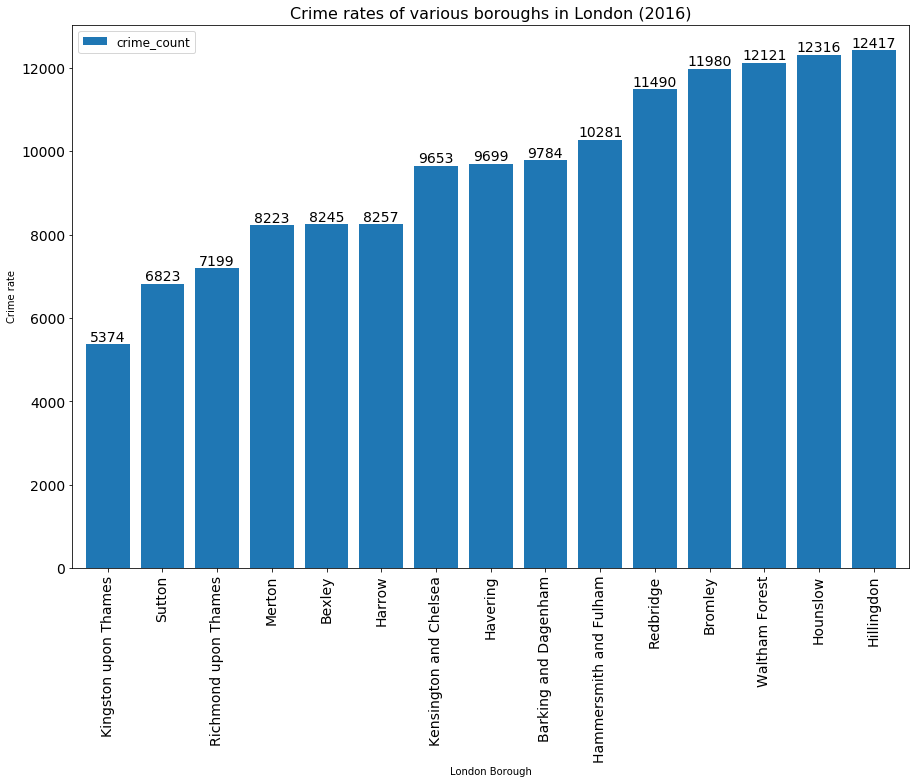

In [21]:
# Visualising the result
import matplotlib.pyplot as plt

ax = df_c.plot(kind='bar',figsize= (15, 10),width= 0.8,fontsize= 14)

ax.set_title("Crime rates of various boroughs in London (2016)", fontsize=16)
ax.set_ylabel('Crime rate')
ax.set_xlabel('London Borough')

ax.legend(prop=dict(size=12))
for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        va = 'top'
        label = y_value

        ax.annotate(label, (x_value, y_value), xytext= (0,14),textcoords="offset points",ha='center',va=va,fontsize=14)

### Visualise the price per m2 in each boroughs of London and extract the 15 values with the least values

In [22]:
df_hp.describe(include='all')

,price per m2
count,32.000000
mean,7473.187500
std,3423.874446
min,3994.000000
25%,5262.500000
50%,6510.000000
75%,8549.750000
max,19439.000000


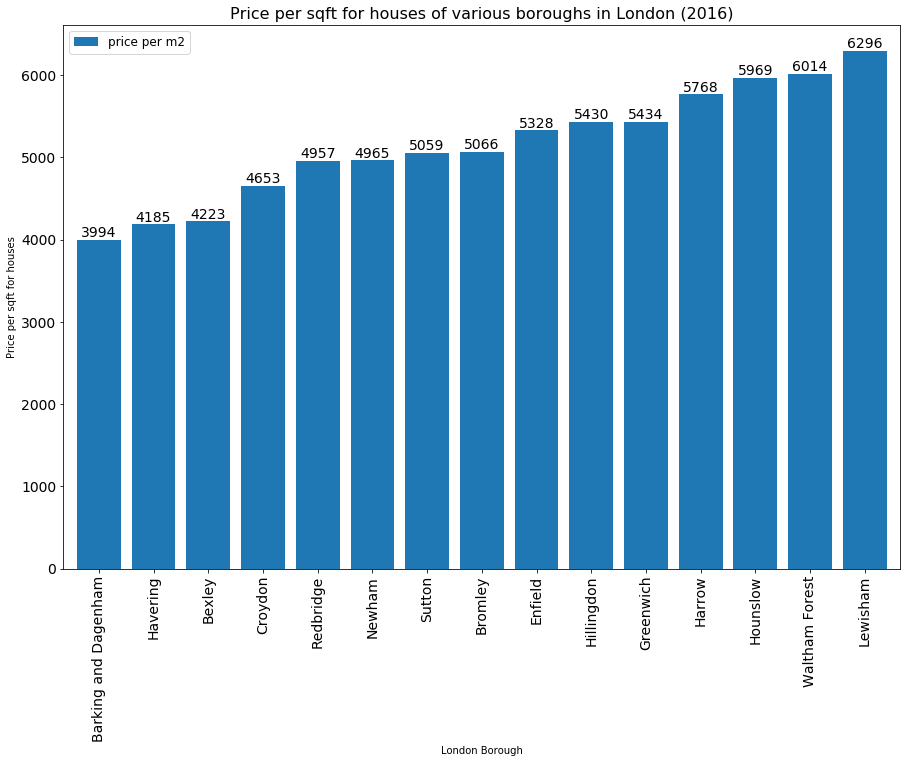

In [23]:
df_hp = df_hp[0:15]
ax = df_hp.plot(kind='bar', figsize= (15, 10),width= 0.8,fontsize= 14)

ax.set_title("Price per sqft for houses of various boroughs in London (2016)", fontsize=16)
ax.set_ylabel('Price per sqft for houses')
ax.set_xlabel('London Borough')

ax.legend(prop=dict(size=12))
for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        va = 'top'
        label = y_value

        ax.annotate(label,(x_value, y_value),xytext= (0,14),textcoords="offset points",ha='center',va=va,fontsize=14)

#### Finding the boroughs which has least crime rates and most affordable houses

In [24]:
common_boroughs_c_hp = df_c.index.intersection(df_hp.index)
df_cb = pd.DataFrame(common_boroughs_c_hp)
df_cb

,London_Borough
0,Sutton
1,Bexley
2,Harrow
3,Havering
4,Barking and Dagenham
5,Redbridge
6,Bromley
7,Waltham Forest
8,Hounslow
9,Hillingdon


### Check the happiness index and get the one with top 15 values

In [25]:
df_hi = happiness_index[0:15]
df_hi

,London_Borough
0,Richmond Upon Thames
1,Kingston upon Thames
2,Bromley
3,Sutton
4,Wandsworth
5,Camden
6,Barnet
7,Ealing
8,Greenwich
9,Havering


In [26]:
# Check the happiness index of the above boroughs and find the best: 
df_cb.merge(df_hi)

,London_Borough
0,Sutton
1,Havering
2,Bromley
3,Waltham Forest


__Considering the crime rates, affordability in terms of price per sq feet and the happiness index, I have decided that theseboroughs in London are the best ones for buying a house: Sutton, Bromley, Havering, Waltham Forest, with Sutton being the best choice.__

It has placed second in terms of least crime rate, seventh in affordability, which is much less than the mean value of houses in London(7473.1875) and fourth in happiness index.

### Explore and cluster the neighborhoods in Sutton

In [27]:
district = []
borough_name = []

neighborhood_details = {}
sutton_wiki = 'https://en.wikipedia.org/wiki/London_Borough_of_Sutton#Districts'
sutton_response = requests.get(sutton_wiki)
sutton_soup_obj = bs4.BeautifulSoup(sutton_response.text, 'html.parser')
district_table = sutton_soup_obj.find(class_='div-col') 

for dist_det in district_table.findAll('li'):
    d1 = dist_det.text.strip()
    dist_name = d1.split('(')[0]
    district.append(dist_name)
    borough_name.append('Sutton')

In [28]:
latitude = []
longitude = []

for dist in district:
    address = '{},London,United Kingdom'.format(dist)
    geolocator = Nominatim(user_agent="London_agent", timeout=10)
    location = geolocator.geocode(address)
    if location:
        latitude.append(location.latitude)
        longitude.append(location.longitude)
    else:
        latitude.append(np.nan)
        longitude.append(np.nan)

print(district,latitude, longitude)

['Bandon Hill', 'Beddington', 'Beddington Corner', 'Belmont', 'Benhilton', 'Carshalton', 'Carshalton Beeches', 'Carshalton on the Hill', 'Cheam', 'Hackbridge', 'Little Woodcote', 'North Cheam', 'Rosehill', 'St. Helier', 'South Beddington', 'Sutton ', 'Sutton Common', 'Sutton High Street ', 'The Wrythe', 'Wallington', 'Woodcote Green', 'Worcester Park'] [51.3647773, 51.3719875, 51.3869422, 51.3437847, 51.3716416, 51.3657883, 51.3571959, nan, 51.3576155, 51.3796135, 51.3460764, 51.3715776, 51.01250455, 51.3866947, 51.3719875, 51.3575114, 51.3753729, 51.3597647, 51.3670587, 51.357945, 51.3479908, 51.3783998] [-0.13483259828506877, -0.1323928, -0.1495322, -0.2011522, -0.1915714, -0.1610857, -0.1693507, nan, -0.2162414, -0.1567541, -0.1459324, -0.220225, -0.1406388422402289, -0.1800574, -0.1323928, -0.173640122600872, -0.1960317, -0.1909906, -0.1629561, -0.1495621, -0.1468304318627454, -0.2416023]


In [29]:
neighborhood_data = {'District': district,'Borough': borough_name, 'Latitude': latitude,'Longitude':longitude}
sutton_neighborhood = pd.DataFrame.from_dict(neighborhood_data)
sutton_neighborhood = sutton_neighborhood.dropna()
sutton_neighborhood

,District,Borough,Latitude,Longitude
0,Bandon Hill,Sutton,51.364777,-0.134833
1,Beddington,Sutton,51.371988,-0.132393
2,Beddington Corner,Sutton,51.386942,-0.149532
3,Belmont,Sutton,51.343785,-0.201152
4,Benhilton,Sutton,51.371642,-0.191571
5,Carshalton,Sutton,51.365788,-0.161086
6,Carshalton Beeches,Sutton,51.357196,-0.169351
8,Cheam,Sutton,51.357616,-0.216241
9,Hackbridge,Sutton,51.379613,-0.156754
10,Little Woodcote,Sutton,51.346076,-0.145932


## Modeling

### Finding all the venues within a 500 meter radius of each neighborhood

In [30]:
CLIENT_ID = '3ACP5FJQJV5ZZC00LGS23WTVM4HDA5R3IVOPS3CRU0BAY3RT'
CLIENT_SECRET = 'K5JKZTM3NOYEODXKZSOSZTFNWTVTT3WLAHBHGJVEPNM5ZNH0'
VERSION = '20180605'

In [31]:
radius = 500
limit = 100

In [32]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET,VERSION,lat,lng,radius,limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(name,lat,lng,v['venue']['name'],v['venue']['location']['lat'],v['venue']['location']['lng'],v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 'District Latitude', 'District Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    
    return(nearby_venues)

In [33]:
sutton_venues = getNearbyVenues(names=sutton_neighborhood['District'],
                                 latitudes=sutton_neighborhood['Latitude'],
                                 longitudes=sutton_neighborhood['Longitude']
                                )

In [35]:
print(sutton_venues.shape)
sutton_venues.head(n=10)

(184, 7)


,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bandon Hill,51.364777,-0.134833,Asif Balti House,51.367795,-0.132356,Indian Restaurant
1,Bandon Hill,51.364777,-0.134833,Sharon’s Perfect Pantry,51.367678,-0.131585,Bakery
2,Bandon Hill,51.364777,-0.134833,Mellows Park,51.360692,-0.134101,Park
3,Beddington,51.371988,-0.132393,Carew Manor,51.370983,-0.136604,Park
4,Beddington,51.371988,-0.132393,Wickes,51.375519,-0.130732,Hardware Store
5,Beddington,51.371988,-0.132393,Asif Balti House,51.367795,-0.132356,Indian Restaurant
6,Beddington,51.371988,-0.132393,The Plough,51.367633,-0.132089,Pub
7,Beddington Corner,51.386942,-0.149532,Traq,51.389091,-0.144979,Racetrack
8,Beddington Corner,51.386942,-0.149532,TNT Croydon Depot,51.389079,-0.144074,Business Service
9,Belmont,51.343785,-0.201152,Belmont Railway Station (BLM),51.343857,-0.198677,Train Station


In [36]:
print('The number of popular venues in each district of Sutton Borough are as follows:')
sutton_venues.groupby('District').count()

The number of popular venues in each district of Sutton Borough are as follows:


,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
District,,,,,,
Bandon Hill,3,3,3,3,3,3
Beddington,4,4,4,4,4,4
Beddington Corner,2,2,2,2,2,2
Belmont,4,4,4,4,4,4
Benhilton,8,8,8,8,8,8
Carshalton,12,12,12,12,12,12
Carshalton Beeches,4,4,4,4,4,4
Cheam,23,23,23,23,23,23
Hackbridge,4,4,4,4,4,4


In [37]:
print('There are %d unique categories of venues in Sutton Borough' % len(sutton_venues['Venue Category'].unique()))
sutton_venues['Venue Category'].unique()

There are 57 unique categories of venues in Sutton Borough


array(['Indian Restaurant', 'Bakery', 'Park', 'Hardware Store', 'Pub',
       'Racetrack', 'Business Service', 'Train Station',
       'Asian Restaurant', 'Bus Stop', 'Gym / Fitness Center',
       'Supermarket', 'Coffee Shop', 'Pizza Place', 'Clothing Store',
       'Grocery Store', 'Hotel', 'Tea Room', 'Platform',
       'Italian Restaurant', 'Thai Restaurant', 'Creperie',
       'American Restaurant', 'Gastropub', 'Stationery Store',
       'Salon / Barbershop', 'Restaurant', 'Soccer Field', 'River',
       'Garden Center', 'Construction & Landscaping', 'Social Club',
       'Seafood Restaurant', 'Turkish Restaurant', 'Fast Food Restaurant',
       'Breakfast Spot', 'Tennis Court', 'Athletics & Sports',
       'Indoor Play Area', 'Portuguese Restaurant', 'Gym', 'Bookstore',
       'Café', 'French Restaurant', 'Sandwich Place', 'Bar', 'Irish Pub',
       'Veterinarian', 'Pharmacy', 'Spanish Restaurant',
       'Fish & Chips Shop', 'BBQ Joint', 'Convenience Store',
       'Cosmetics S

### Onehot encoding

In [38]:
sutton_onehot = pd.get_dummies(sutton_venues[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
sutton_onehot['District'] = sutton_venues['District'] 
column_names = [sutton_onehot.columns[-1]] + list(sutton_onehot.columns[0:-1])
sutton_onehot = sutton_onehot[column_names]
sutton_onehot.head()

,District,American Restaurant,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,Bookstore,Breakfast Spot,Bus Stop,Business Service,Café,Clothing Store,Coffee Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Fast Food Restaurant,Fish & Chips Shop,French Restaurant,Garden Center,Gastropub,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Hotel,Indian Restaurant,Indoor Play Area,Irish Pub,Italian Restaurant,Lebanese Restaurant,Park,Pet Service,Pet Store,Pharmacy,Pizza Place,Platform,Portuguese Restaurant,Pub,Racetrack,Restaurant,River,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Soccer Field,Social Club,Spanish Restaurant,Stationery Store,Supermarket,Tea Room,Tennis Court,Thai Restaurant,Train Station,Turkish Restaurant,Veterinarian
0,Bandon Hill,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Bandon Hill,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Bandon Hill,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Beddington,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Beddington,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [39]:
# Grouping by neighbourhood and calculating the mean
sutton_grouped = sutton_onehot.groupby("District").mean().reset_index()
sutton_grouped.head()

,District,American Restaurant,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,Bookstore,Breakfast Spot,Bus Stop,Business Service,Café,Clothing Store,Coffee Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Fast Food Restaurant,Fish & Chips Shop,French Restaurant,Garden Center,Gastropub,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Hotel,Indian Restaurant,Indoor Play Area,Irish Pub,Italian Restaurant,Lebanese Restaurant,Park,Pet Service,Pet Store,Pharmacy,Pizza Place,Platform,Portuguese Restaurant,Pub,Racetrack,Restaurant,River,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Soccer Field,Social Club,Spanish Restaurant,Stationery Store,Supermarket,Tea Room,Tennis Court,Thai Restaurant,Train Station,Turkish Restaurant,Veterinarian
0,Bandon Hill,0.0,0.00,0.0,0.0,0.333333,0.0,0.0,0.0,0.00,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.00,0.0,0.333333,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.00,0.0,0.0
1,Beddington,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.25,0.0,0.250000,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.0,0.000,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.00,0.0,0.0
2,Beddington Corner,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.5,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0,0.00,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.00,0.0,0.0
3,Belmont,0.0,0.25,0.0,0.0,0.000000,0.0,0.0,0.0,0.25,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.25,0.0,0.0
4,Benhilton,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.125,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.125,0.00,0.0,0.125000,0.0,0.0,0.0,0.0,0.125000,0.0,0.0,0.0,0.125,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.00,0.0,0.0


In [64]:
num_top_venues = 3

for hood in sutton_grouped['District']:
    print("***********"+hood+"***********")
    temp = sutton_grouped[sutton_grouped['District'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

***********Bandon Hill***********
               venue  freq
0  Indian Restaurant  0.33
1               Park  0.33
2             Bakery  0.33


***********Beddington***********
               venue  freq
0  Indian Restaurant  0.25
1               Park  0.25
2     Hardware Store  0.25


***********Beddington Corner***********
                 venue  freq
0     Business Service   0.5
1            Racetrack   0.5
2  American Restaurant   0.0


***********Belmont***********
              venue  freq
0  Asian Restaurant  0.25
1     Train Station  0.25
2          Bus Stop  0.25


***********Benhilton***********
         venue  freq
0         Park  0.12
1  Pizza Place  0.12
2  Coffee Shop  0.12


***********Carshalton***********
           venue  freq
0           Park  0.17
1  Grocery Store  0.17
2            Pub  0.17


***********Carshalton Beeches***********
           venue  freq
0  Train Station  0.25
1         Bakery  0.25
2  Grocery Store  0.25


***********Cheam***********
           

In [65]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [66]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['District'] = sutton_grouped['District']

for ind in np.arange(sutton_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sutton_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bandon Hill,Bakery,Park,Indian Restaurant,Veterinarian,Cosmetics Shop,Hardware Store,Gym / Fitness Center,Gym,Grocery Store,Gastropub
1,Beddington,Indian Restaurant,Hardware Store,Park,Pub,Hotel,Gym / Fitness Center,Gym,Grocery Store,Gastropub,Garden Center
2,Beddington Corner,Business Service,Racetrack,Veterinarian,Convenience Store,Hardware Store,Gym / Fitness Center,Gym,Grocery Store,Gastropub,Garden Center
3,Belmont,Train Station,Asian Restaurant,Bus Stop,Pub,Veterinarian,Convenience Store,Gym / Fitness Center,Gym,Grocery Store,Gastropub
4,Benhilton,Indian Restaurant,Gym / Fitness Center,Grocery Store,Supermarket,Park,Pizza Place,Clothing Store,Coffee Shop,Cosmetics Shop,Gym


### Clustering

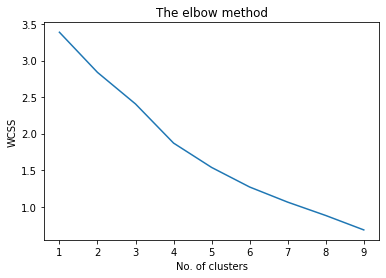

In [67]:
from sklearn.cluster import KMeans
wcss = []

sutton_grouped_clustering = sutton_grouped.drop('District', 1)

for i in range(1,10):
    kmeans = KMeans(n_clusters = i, init= 'k-means++', max_iter=2000, n_init=10, random_state =0)
    kmeans.fit(sutton_grouped_clustering)
    wcss.append(kmeans.inertia_) #calculate wcss and append it to a list
plt.plot(range(1,10), wcss)
plt.title('The elbow method')
plt.xlabel('No. of clusters')
plt.ylabel('WCSS')
plt.show()

In [68]:
# run k-means clustering
kmeans = KMeans(n_clusters=6, random_state=0).fit(sutton_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 4, 2, 2, 2, 0, 2, 2, 3])

In [69]:
neighborhoods_venues_sorted.iloc[0:0]
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted
sutton_merged = sutton_neighborhood

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
sutton_merged= sutton_merged.join(neighborhoods_venues_sorted.set_index('District'), on='District')

sutton_merged.head()

,District,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bandon Hill,Sutton,51.364777,-0.134833,1,Bakery,Park,Indian Restaurant,Veterinarian,Cosmetics Shop,Hardware Store,Gym / Fitness Center,Gym,Grocery Store,Gastropub
1,Beddington,Sutton,51.371988,-0.132393,1,Indian Restaurant,Hardware Store,Park,Pub,Hotel,Gym / Fitness Center,Gym,Grocery Store,Gastropub,Garden Center
2,Beddington Corner,Sutton,51.386942,-0.149532,4,Business Service,Racetrack,Veterinarian,Convenience Store,Hardware Store,Gym / Fitness Center,Gym,Grocery Store,Gastropub,Garden Center
3,Belmont,Sutton,51.343785,-0.201152,2,Train Station,Asian Restaurant,Bus Stop,Pub,Veterinarian,Convenience Store,Gym / Fitness Center,Gym,Grocery Store,Gastropub
4,Benhilton,Sutton,51.371642,-0.191571,2,Indian Restaurant,Gym / Fitness Center,Grocery Store,Supermarket,Park,Pizza Place,Clothing Store,Coffee Shop,Cosmetics Shop,Gym


### Map of Sutton with the district and cluster details

In [70]:
address = 'Sutton,London,United Kingdom '

geolocator = Nominatim(user_agent="sutton_explorer", timeout=3)
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Sutton are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Sutton are 51.3575114, -0.173640122600872.


In [71]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(6)
ys = [i + x + (i*x)**2 for i in range(6)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sutton_merged['Latitude'], sutton_merged['Longitude'], sutton_merged['District'], sutton_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker([lat, lon],radius=5,popup=label,color=rainbow[cluster-1],fill=True,fill_color=rainbow[cluster-1],fill_opacity=0.7).add_to(map_clusters)
       
        
map_clusters

### Examine the clusters

In [72]:
sutton_merged[sutton_merged['Cluster Labels'] == 0]

,District,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Carshalton Beeches,Sutton,51.357196,-0.169351,0,Train Station,Italian Restaurant,Bakery,Grocery Store,Veterinarian,Convenience Store,Gym / Fitness Center,Gym,Gastropub,Garden Center
15,Sutton,Sutton,51.357511,-0.173640,0,Train Station,Italian Restaurant,Bakery,Grocery Store,Park,Veterinarian,Convenience Store,Gym / Fitness Center,Gym,Gastropub


In [73]:
sutton_merged[sutton_merged['Cluster Labels'] == 1]

,District,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bandon Hill,Sutton,51.364777,-0.134833,1,Bakery,Park,Indian Restaurant,Veterinarian,Cosmetics Shop,Hardware Store,Gym / Fitness Center,Gym,Grocery Store,Gastropub
1,Beddington,Sutton,51.371988,-0.132393,1,Indian Restaurant,Hardware Store,Park,Pub,Hotel,Gym / Fitness Center,Gym,Grocery Store,Gastropub,Garden Center
14,South Beddington,Sutton,51.371988,-0.132393,1,Indian Restaurant,Hardware Store,Park,Pub,Hotel,Gym / Fitness Center,Gym,Grocery Store,Gastropub,Garden Center


In [74]:
sutton_merged[sutton_merged['Cluster Labels'] == 2]

,District,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Belmont,Sutton,51.343785,-0.201152,2,Train Station,Asian Restaurant,Bus Stop,Pub,Veterinarian,Convenience Store,Gym / Fitness Center,Gym,Grocery Store,Gastropub
4,Benhilton,Sutton,51.371642,-0.191571,2,Indian Restaurant,Gym / Fitness Center,Grocery Store,Supermarket,Park,Pizza Place,Clothing Store,Coffee Shop,Cosmetics Shop,Gym
5,Carshalton,Sutton,51.365788,-0.161086,2,Grocery Store,Park,Pub,Coffee Shop,Gym / Fitness Center,Platform,Hotel,Train Station,Tea Room,Bakery
8,Cheam,Sutton,51.357616,-0.216241,2,Pub,Italian Restaurant,Grocery Store,Thai Restaurant,Restaurant,Gym / Fitness Center,Indian Restaurant,Creperie,Train Station,Park
9,Hackbridge,Sutton,51.379613,-0.156754,2,Train Station,Supermarket,Park,River,Veterinarian,Construction & Landscaping,Gym,Grocery Store,Gastropub,Garden Center
11,North Cheam,Sutton,51.371578,-0.220225,2,Coffee Shop,Soccer Field,Pub,Gym / Fitness Center,Fast Food Restaurant,Seafood Restaurant,Social Club,Supermarket,Turkish Restaurant,Grocery Store
12,Rosehill,Sutton,51.012505,-0.140639,2,Restaurant,Grocery Store,Business Service,Pub,Veterinarian,Gym / Fitness Center,Gym,Gastropub,Garden Center,French Restaurant
16,Sutton Common,Sutton,51.375373,-0.196032,2,Indoor Play Area,Gym / Fitness Center,Athletics & Sports,Tennis Court,Grocery Store,Park,Convenience Store,Gym,Gastropub,Garden Center
17,Sutton High Street,Sutton,51.359765,-0.190991,2,Pub,Coffee Shop,Pizza Place,Café,Bar,Italian Restaurant,Portuguese Restaurant,Gym,Park,Clothing Store
18,The Wrythe,Sutton,51.367059,-0.162956,2,Pub,Café,Grocery Store,Park,Veterinarian,Platform,Gym / Fitness Center,Coffee Shop,Hotel,Train Station


In [75]:
sutton_merged[sutton_merged['Cluster Labels'] == 3]

,District,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Little Woodcote,Sutton,51.346076,-0.145932,3,Construction & Landscaping,Park,Garden Center,Coffee Shop,Convenience Store,Hardware Store,Gym / Fitness Center,Gym,Grocery Store,Gastropub
20,Woodcote Green,Sutton,51.347991,-0.146830,3,Construction & Landscaping,Park,Garden Center,Coffee Shop,Convenience Store,Hardware Store,Gym / Fitness Center,Gym,Grocery Store,Gastropub


In [76]:
sutton_merged[sutton_merged['Cluster Labels'] == 4]

,District,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Beddington Corner,Sutton,51.386942,-0.149532,4,Business Service,Racetrack,Veterinarian,Convenience Store,Hardware Store,Gym / Fitness Center,Gym,Grocery Store,Gastropub,Garden Center


In [77]:

sutton_merged[sutton_merged['Cluster Labels'] == 5]

,District,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,St. Helier,Sutton,51.386695,-0.180057,5,Breakfast Spot,Coffee Shop,Veterinarian,Convenience Store,Hardware Store,Gym / Fitness Center,Gym,Grocery Store,Gastropub,Garden Center


**While considering the move to London, we analysed the various boroughs based on crime rate and affordability in terms of price per square feet of the houses. I also came across a survey result by itv on the happiness index of the people in these boroughs. Considering the following factors, we concluded that Sutton, Bromley, Havering, Waltham Forest are the best boroughs for buying a house in London, with Sutton being the most ideal choice for me.**